<a href="https://colab.research.google.com/github/daveselinger/covid-19-hackathon/blob/master/by_state_covid_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Purpose**

The purpose of this analysis is to help people understand the severity of the COVID19 in a more realistic fashion.

We, the authors, believe that the analysis of COVID19 using national data is lacking in precision and actionability. Further, we feel that it may not be really representative of the "on-the-ground" experience: i.e., you can't average the experience of rural Montana with that of metropolitan Manhattan; or in fact even compare the metropolitan area of Seattle with that in San Diego.

**Open Source**

This code, its methodology, and conclusions are all released without any additional warranties or expectations using the MIT Open Source License.

**Social implications and responsibility**

While we are statisticians we recognize that there may be conclusions drawn from this analysis that have political and or personal ramifications for people. We therefore release this information to the open source with the best of intentions and with the hopes that these conclusions are used to save lives in a period of intense anxiety and volatility. In a world when it is hard to know "which facts" to believe, we have done everything we can to remove bias, to be explicit and transparent in the assumptions made and to be clear of our intent: We believe that more data will be better; we are disappointed in the lack of testing data -- and that is clear from our conclusions (these conslusions must be caveated with the fact that our model is affected by the variance because of the CDC's inability to test at the scale needed to face this problem); we believe that even with this volatility of data in a time of such dire consequences as has been proven in Wuhan China and Northern Italy, to not reach the best possible conclusions based on the data that we do have would be a dereliction of our duty and an act of ignorance. Therefore we submit this analysis and conclusions with nothing less than the best hopes for our citizens and with the desire for our local and state governments to do what is necessary regardless of any resistance they may face: We implore state health departments to act faster--even faster than the CDC and FDA might desire.


In [40]:
!wget https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
!pip install -U plotly
!pip install plotly-geo
!pip install geopandas==0.3.0
!pip install pyshp==1.2.10
!pip install chart-studio


--2020-03-22 16:04:26--  https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-Confirmed.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81207 (79K) [text/plain]
Saving to: ‘time_series_19-covid-Confirmed.csv.2’

time_series_19-covi 100%[===================>]  79.30K  --.-KB/s    in 0.01s   

2020-03-22 16:04:26 (5.48 MB/s) - ‘time_series_19-covid-Confirmed.csv.2’ saved [81207/81207]

Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.5.4)


In [41]:
from __future__ import print_function

import numpy as np 
import chart_studio.plotly as py
import plotly.figure_factory as ff
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
import datetime
import math
import scipy

pd.__version__


'0.25.3'

In [42]:
covid_across_countries_df = pd.read_csv('time_series_19-covid-Confirmed.csv')
global_timeseries = covid_across_countries_df.set_index(['Country/Region'])
global_timeseries.head(10)


,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Thailand,NaN,15.0000,101.0000,2,3,5,7,8,8,14,14,14,19,19,19,19,25,25,25,25,32,32,32,33,33,33,33,33,34,35,35,35,35,35,35,35,35,37,40,40,41,42,42,43,43,43,47,48,50,50,50,53,59,70,75,82,114,147,177,212,272,322,411
Japan,NaN,36.0000,138.0000,2,1,2,2,4,4,7,7,11,15,20,20,20,22,22,45,25,25,26,26,26,28,28,29,43,59,66,74,84,94,105,122,147,159,170,189,214,228,241,256,274,293,331,360,420,461,502,511,581,639,639,701,773,839,825,878,889,924,963,1007
Singapore,NaN,1.2833,103.8333,0,1,3,3,4,5,7,7,10,13,16,18,18,24,28,28,30,33,40,45,47,50,58,67,72,75,77,81,84,84,85,85,89,89,91,93,93,93,102,106,108,110,110,117,130,138,150,150,160,178,178,200,212,226,243,266,313,345,385,432
Nepal,NaN,28.1667,84.2500,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Malaysia,NaN,2.5000,112.5000,0,0,0,3,4,4,4,7,8,8,8,8,8,10,12,12,12,16,16,18,18,18,19,19,22,22,22,22,22,22,22,22,22,22,22,22,23,23,25,29,29,36,50,50,83,93,99,117,129,149,149,197,238,428,566,673,790,900,1030,1183
Canada,British Columbia,49.2827,-123.1207,0,0,0,0,0,0,1,1,1,1,1,1,1,1,2,2,4,4,4,4,4,4,4,4,4,4,5,5,5,5,6,6,6,6,7,7,7,7,8,8,8,9,12,13,21,21,27,32,32,39,46,64,64,73,103,103,186,231,271,424
Australia,New South Wales,-33.8688,151.2093,0,0,0,0,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,6,6,13,22,22,26,28,38,48,55,65,65,92,112,134,171,210,267,307,353,436
Australia,Victoria,-37.8136,144.9631,0,0,0,0,1,1,1,1,2,3,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,4,7,7,9,9,10,10,10,11,11,15,18,21,21,36,49,57,71,94,121,121,121,229
Australia,Queensland,-28.0167,153.4000,0,0,0,0,0,0,0,1,3,2,3,2,2,3,3,4,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,5,9,9,9,11,11,13,13,13,15,15,18,20,20,35,46,61,68,78,94,144,184,221


In [43]:
us_timeseries = global_timeseries.loc[['US']]
us_timeseries.head(5)

,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
US,Washington,47.4009,-121.4905,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,267,366,442,568,572,643,904,1076,1014,1376,1524,1793
US,New York,42.1657,-74.9481,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,173,220,328,421,525,732,967,1706,2495,5365,8310,11710
US,California,36.1162,-119.6816,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,144,177,221,282,340,426,557,698,751,952,1177,1364
US,Massachusetts,42.2302,-71.5301,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,92,95,108,123,138,164,197,218,218,328,413,525
US,Diamond Princess,35.4437,139.6380,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,36,36,42,42,44,44,44,45,45,45,45,45,45,45,45,46,46,46,46,46,46,47,47,47,47,49,49


Now that we have the US data isloated, we can input this into a spatio-temporal map: Space represented as a map, and temporal as an animation.


In [44]:
!wget http://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?#
state_populations = pd.read_csv('nst-est2019-alldata.csv?', index_col='NAME')
state_populations.head(10)



URL transformed to HTTPS due to an HSTS policy
--2020-03-22 16:04:41--  https://www2.census.gov/programs-surveys/popest/datasets/2010-2019/national/totals/nst-est2019-alldata.csv?
Resolving www2.census.gov (www2.census.gov)... 23.51.214.235, 2600:1409:a:39b::208c, 2600:1409:a:38c::208c
Connecting to www2.census.gov (www2.census.gov)|23.51.214.235|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘nst-est2019-alldata.csv?.2’

nst-est2019-alldata     [ <=>                ]  72.35K  --.-KB/s    in 0.01s   

2020-03-22 16:04:42 (4.83 MB/s) - ‘nst-est2019-alldata.csv?.2’ saved [74085]



,SUMLEV,REGION,DIVISION,STATE,CENSUS2010POP,ESTIMATESBASE2010,POPESTIMATE2010,POPESTIMATE2011,POPESTIMATE2012,POPESTIMATE2013,POPESTIMATE2014,POPESTIMATE2015,POPESTIMATE2016,POPESTIMATE2017,POPESTIMATE2018,POPESTIMATE2019,NPOPCHG_2010,NPOPCHG_2011,NPOPCHG_2012,NPOPCHG_2013,NPOPCHG_2014,NPOPCHG_2015,NPOPCHG_2016,NPOPCHG_2017,NPOPCHG_2018,NPOPCHG_2019,BIRTHS2010,BIRTHS2011,BIRTHS2012,BIRTHS2013,BIRTHS2014,BIRTHS2015,BIRTHS2016,BIRTHS2017,BIRTHS2018,BIRTHS2019,DEATHS2010,DEATHS2011,DEATHS2012,DEATHS2013,...,RDEATH2016,RDEATH2017,RDEATH2018,RDEATH2019,RNATURALINC2011,RNATURALINC2012,RNATURALINC2013,RNATURALINC2014,RNATURALINC2015,RNATURALINC2016,RNATURALINC2017,RNATURALINC2018,RNATURALINC2019,RINTERNATIONALMIG2011,RINTERNATIONALMIG2012,RINTERNATIONALMIG2013,RINTERNATIONALMIG2014,RINTERNATIONALMIG2015,RINTERNATIONALMIG2016,RINTERNATIONALMIG2017,RINTERNATIONALMIG2018,RINTERNATIONALMIG2019,RDOMESTICMIG2011,RDOMESTICMIG2012,RDOMESTICMIG2013,RDOMESTICMIG2014,RDOMESTICMIG2015,RDOMESTICMIG2016,RDOMESTICMIG2017,RDOMESTICMIG2018,RDOMESTICMIG2019,RNETMIG2011,RNETMIG2012,RNETMIG2013,RNETMIG2014,RNETMIG2015,RNETMIG2016,RNETMIG2017,RNETMIG2018,RNETMIG2019
NAME,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
United States,10,0,0,0,308745538,308758105,309321666,311556874,313830990,315993715,318301008,320635163,322941311,324985539,326687501,328239523,563561,2235208,2274116,2162725,2307293,2334155,2306148,2044228,1701962,1552022,987836,3973485,3936976,3940576,3963195,3992376,3962654,3901982,3824521,3791712,598691,2512442,2501531,2608019,...,8.400602,8.606413,8.668095,8.657569,4.706373,4.590575,4.231517,4.353645,4.045944,3.913875,3.438101,3.069450,2.921467,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.493773,2.682083,2.636187,2.921500,3.260435,3.252788,2.871957,2.153911,1.818059
Northeast Region,20,1,0,0,55317240,55318443,55380134,55604223,55775216,55901806,56006011,56034684,56042330,56059240,56046620,55982803,61691,224089,170993,126590,104205,28673,7646,16910,-12620,-63817,163466,646249,637860,635751,632433,634504,628030,618490,610713,602740,110878,470811,460915,479963,...,8.574497,8.883355,8.975017,9.025986,3.161491,3.177337,2.789974,2.898189,2.593611,2.632618,2.151103,1.920274,1.734402,3.680555,3.681434,3.428960,3.931182,4.009115,4.177449,3.809171,3.195141,2.394817,-2.792646,-3.719789,-3.898743,-4.917279,-6.071080,-6.667933,-5.646219,-5.329588,-5.254530,0.887909,-0.038355,-0.469783,-0.986097,-2.061965,-2.490484,-1.837048,-2.134447,-2.859713
Midwest Region,20,2,0,0,66927001,66929725,66974416,67157800,67336743,67560379,67745167,67860583,67987540,68126781,68236628,68329004,44691,183384,178943,223636,184788,115416,126957,139241,109847,92376,212570,834866,830701,830890,836538,838012,831641,818785,801587,792343,140862,586660,584671,605165,...,9.115871,9.409840,9.209377,9.121680,3.700916,3.658587,3.346624,3.542205,3.125649,3.127816,2.621003,2.547252,2.482162,1.713906,1.767566,1.845688,1.951908,2.070856,2.106735,1.825671,1.380898,1.254708,-2.677835,-2.741509,-1.852612,-2.714878,-3.459293,-3.348519,-2.383041,-2.303653,-2.365881,-0.963930,-0.973943,-0.006924,-0.762969,-1.388437,-1.241784,-0.557370,-0.922755,-1.111173
South Region,20,3,0,0,114555744,114563030,114866680,116006522,117241208,118364400,119624037,120997341,122351760,123542189,124569433,125580448,303650,1139842,1234686,1123192,1259637,1373304,1354419,1190429,1027244,1011015,368759,1509634,1504955,1504774,1525313,1545679,1541412,1519344,1494950,1481244,228435,963051,960791,1011227,...,8.695993,8.884440,9.003440,8.971661,4.734919,4.665975,4.189603,4.363271,4.101489,3.972326,3.473278,3.047185,2.871191,2.422447,2.898420,2.745376,3.013508,3.507594,3.521386,3.220112,2.415429,1.942372,2.708067,2.952037,2.546697,3.147993,3.769765,3.628688,2.978056,2.810090,3.261349,5.130513,5.850458,5.292073,6.161501,7.277358,7.150074,6.198168,5.225519,5.203720
West Regio

Get append data including population, hospitals, hospital beds.

In [45]:
#Need these abbreviations because Plotly requires 2-letter state abbreviations.

us_state_abbrev = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'District of Columbia': 'DC',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Northern Mariana Islands':'MP',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Palau': 'PW',
    'Pennsylvania': 'PA',
    'Puerto Rico': 'PR',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virgin Islands': 'VI',
    'Virginia': 'VA',
    'Washington': 'WA',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

# filter out some of the states in the state_populations like the Diamond Princess
good_states = state_populations.index.intersection(us_state_abbrev.keys())

us_state_pop = {}
for state_name in good_states:
  state_row = state_populations.loc[state_name]
  us_state_pop[state_name]=state_row["POPESTIMATE2019"]

print (us_state_pop)

{'Alabama': 4903185, 'Alaska': 731545, 'Arizona': 7278717, 'Arkansas': 3017804, 'California': 39512223, 'Colorado': 5758736, 'Connecticut': 3565287, 'Delaware': 973764, 'District of Columbia': 705749, 'Florida': 21477737, 'Georgia': 10617423, 'Hawaii': 1415872, 'Idaho': 1787065, 'Illinois': 12671821, 'Indiana': 6732219, 'Iowa': 3155070, 'Kansas': 2913314, 'Kentucky': 4467673, 'Louisiana': 4648794, 'Maine': 1344212, 'Maryland': 6045680, 'Massachusetts': 6892503, 'Michigan': 9986857, 'Minnesota': 5639632, 'Mississippi': 2976149, 'Missouri': 6137428, 'Montana': 1068778, 'Nebraska': 1934408, 'Nevada': 3080156, 'New Hampshire': 1359711, 'New Jersey': 8882190, 'New Mexico': 2096829, 'New York': 19453561, 'North Carolina': 10488084, 'North Dakota': 762062, 'Ohio': 11689100, 'Oklahoma': 3956971, 'Oregon': 4217737, 'Pennsylvania': 12801989, 'Rhode Island': 1059361, 'South Carolina': 5148714, 'South Dakota': 884659, 'Tennessee': 6829174, 'Texas': 28995881, 'Utah': 3205958, 'Vermont': 623989, 'Vi

**Hospitals**

Next we analyze hospitals. We use data from [ArcGIS OpenData](https://hifld-geoplatform.opendata.arcgis.com/datasets/hospitals/data) but for some reason I couldn't download this using a link, so I pulled it into Github and just stored it there.

**Assumptions**

These data have 2-3 key assumptions made in the modeling:
1. We assume that the only beds that can be used for ICU are in the "General Acute Care" class of hospital.
2. We assume that ICU beds comprise approximately 15%. We did not find a data set containing ICU details per state. This was based on an article from the NIH here: [https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5520980/](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5520980/)

In [46]:
hospital_beds_df = pd.read_csv('https://raw.githubusercontent.com/daveselinger/covid-19-hackathon/master/Hospitals.csv')
hospital_beds_df.replace(to_replace=-999, value=1, inplace=True)
print (hospital_beds_df.set_index('STATE').loc['AK'].head(5))
print (hospital_beds_df.groupby('TYPE').sum())

hospital_beds_df.index.value_counts()

hospital_bed_count_df = hospital_beds_df.where(hospital_beds_df['TYPE'] == "GENERAL ACUTE CARE").groupby('STATE')['BEDS'].sum()

                X          Y  OBJECTID  ...  BEDS    TRAUMA HELIPAD
STATE                                   ...                        
AK    -151.077827  60.493169       635  ...   108  LEVEL II       Y
AK    -149.800293  61.182950       636  ...   148  LEVEL II       N
AK    -131.685788  55.353719       637  ...    54  LEVEL IV       Y
AK    -147.739393  64.831745       638  ...   217  LEVEL IV       Y
AK    -165.405315  64.501918       639  ...    36  LEVEL IV       N

[5 rows x 33 columns]
                                X              Y  ...  TTL_STAFF    BEDS
TYPE                                              ...                   
CHILDREN            -11434.801713    4568.912875  ...        124   16853
CHRONIC DISEASE       -660.310220     369.804715  ...          9    1414
CRITICAL ACCESS     -99135.887396   41965.188956  ...       1031   27440
GENERAL ACUTE CARE -415767.410650  167018.239174  ...       4524  831577
LONG TERM CARE      -39202.381094   15554.476288  ...        43

**Computing State-by-State Statistics**

Some key assumptions in computing these data:
- 40% of cases will need hospitalization
- 15% of cases will need an ICU
- ICU's are 15% of total beds in a hospital
- 90% of the cases are in the key metropolitan area of the state (which is where the outbreak will occur in a state most likely due to virality/spread -- this is NOT ACTUALLY the case if we had metro/county level data which would be much more accurate)
- 40% of the population (and importantly here hospital beds/icu beds) are in this metropolitan areas

**Key assumptions and the desire to repeat this analysis with county-level data**

These last 2 assumptions are particularly important as the population-density of a state is not flat across its population. The most likely places for broadly spreading COVID are in places where many people are interacting frequently (i.e., metropolitan areas). Therefore, we have made the assumption that the case-incident data would reflect this distribution of cases. We chose 90% as an assumption based on the virulence and high R0 of this disease--the higher this value, the more exaggerated the impact of even a very few cases in a dense metro area. Furthermore, we estimate that only 40% of the population of a state lives in this based on an approximation from the WAPO combining "Metropolitan" and "Big City"
https://www.washingtonpost.com/business/2018/12/18/americans-say-theres-not-much-appeal-big-city-living-why-do-so-many-us-live-there/ (which indicates 12% big city, 21% big city suburb)

We recognize that these assumptions would be far better handled by having case data, hospital (& ICU data) and population by county, but those data were not available to the best of our knowledge.

In [47]:
GROWTH_RATE_MIN_THRESHOLD=100
days_to_fit=4
icu_case_ratio=0.15
invalid_date=datetime.date(2019,1,1)
def calcBaseGR(days):
  base_data=us_timeseries.iloc[:,51:51+days-1].sum()
  results=scipy.optimize.curve_fit(lambda day,gr: np.log(base_data[0])+np.log(gr)*day,  range(len(base_data)),  np.log(base_data),  p0=(2))
  #results=scipy.optimize.curve_fit(lambda day,gr: np.log(data[-days_to_fit])+np.log(gr)*day,  range(days_to_fit),  np.log(data[-days_to_fit:]),  p0=(2))
  base_GR=float(results[0][0])
  return base_GR,base_data

def create_dfs(enddate=datetime.datetime.today().date(),startdate=datetime.date(2020,3,10),case_concentration=1.0, population_concentration=1.0):
  ts=us_timeseries.reset_index()
  days=(enddate - startdate).days 
  base_GR,_=calcBaseGR(days)


  def func(data,base_GR):
    if data[-1]<GROWTH_RATE_MIN_THRESHOLD or len(data)<days_to_fit:
      return base_GR
    if np.any(data == 0):
      return base_GR
    logdata=[math.log(x) for x in data[-days_to_fit:]]
    fit=scipy.optimize.curve_fit(lambda day,gr: logdata[0]+np.log(gr)*day,  range(days_to_fit),  logdata,  p0=(1.0))
    return float(fit[0][0])
  growth_df=pd.DataFrame({"state_name":ts.loc[:,'Province/State'],
                    'GR':ts.apply(lambda x: func(x.iloc[51+days-days_to_fit:51+days].to_numpy(),base_GR),axis=1),
                    'Count':ts.iloc[:,51+days-1]})
  
  growth_df['State'] = growth_df.state_name.map(us_state_abbrev)
  growth_df = growth_df.dropna(subset=['State'])
  growth_df['Growth Rate']=(growth_df.GR-1)*100
  growth_df['Days to Double'] = np.log(2)/np.log(growth_df.GR)
  growth_df['Population'] = growth_df.state_name.map(us_state_pop)
  growth_df['Beds'] = growth_df.State.map(hospital_bed_count_df)
  growth_df['Beds Percent'] = growth_df.Beds
  beds_in_metro = growth_df.Beds * population_concentration
  growth_df['Population Percent (1/100 of 1%)'] = growth_df.Count * 10000.0 / growth_df.Population
  cases_needing_beds_in_metro = growth_df.Count * case_concentration * .4
  growth_df['Beds Percent'] = cases_needing_beds_in_metro * 100.0 / (beds_in_metro)
  growth_df['ICU'] = growth_df.Beds * icu_case_ratio
  growth_df['Beds per 1000'] = 1000.0 * growth_df.Beds / growth_df.Population
  cases_needing_icu_in_metro = growth_df.Count * case_concentration * .15
  icu_beds_in_metro = growth_df.ICU * population_concentration
  growth_df['ICU Percent'] = cases_needing_icu_in_metro * 100.0 / (icu_beds_in_metro)
  multiplier_to_fill_icu = 1.0 / (growth_df['ICU Percent']/100)
  growth_df['Days To ICU Capacity']=np.log(multiplier_to_fill_icu)/np.log(growth_df.GR)
  growth_df['Beds per 1000'] = 1000.0 * growth_df.Beds / growth_df.Population
  growth_df['EstimateDate']=enddate
  valid_dates=np.isfinite(growth_df['Days To ICU Capacity'])
  def func(days):
    return enddate+datetime.timedelta(days=int(days))
  growth_df['ICU Full Date']=growth_df[valid_dates].apply(lambda x: func(x['Days To ICU Capacity']),axis=1)
  growth_df['FirstDataDate']=startdate
  return  growth_df

def create_plot_dfs(enddate=datetime.datetime.today().date(),startdate=datetime.date(2020,3,10),threshold=None):
  ts=us_timeseries.reset_index()
  plot_df=ts.melt(id_vars=['Province/State'],var_name="Day",value_vars=ts.columns[52:],value_name="Count")
  plot_df=plot_df.rename(columns={'Province/State':'State'})
  if threshold is not None:
    plot_df=plot_df[plot_df.Count>threshold]
  plot_df['State']=plot_df.State.map(us_state_abbrev)
  plot_df['Day']=plot_df.Day
  plot_df['Date']=pd.to_datetime(plot_df.Day)
  return plot_df

us_growthseries_df=create_dfs()
us_plotseries_df=create_plot_dfs()
us_plot100series_df=create_plot_dfs(threshold=100)
us_growthseries_df.head(1)

,state_name,GR,Count,State,Growth Rate,Days to Double,Population,Beds,Beds Percent,Population Percent (1/100 of 1%),ICU,Beds per 1000,ICU Percent,Days To ICU Capacity,EstimateDate,ICU Full Date,FirstDataDate
0,Washington,1.111248,1524,WA,11.12484,6.571108,7614893.0,11292.0,5.398512,2.001341,1693.8,1.482884,13.496281,18.986336,2020-03-22,2020-04-09,2020-03-10


Verify that growth rate estimation looks reasonable

Growth rate = 1.70


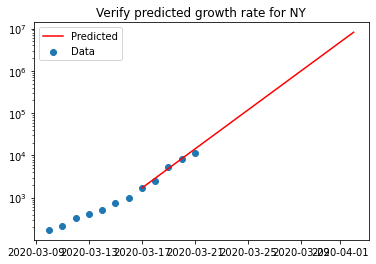

In [48]:
predictdays=14
state='NY'
cdata=us_plotseries_df.query("State=='{}'".format(state))
crow=us_growthseries_df.query("State=='{}'".format(state))
startdate=crow.EstimateDate.values[0]-datetime.timedelta(days=days_to_fit+1)
enddate=startdate+datetime.timedelta(days=predictdays-1+days_to_fit-1)
daterange=pd.date_range(startdate,enddate).tolist()
print("Growth rate = {:.2f}".format(crow.GR.values[0]))
data=[crow.Count.values[0]*pow(crow.GR.values[0],d) for d in range(1-days_to_fit,predictdays)]
plt.figure()
plt.scatter(cdata.Date.values,cdata.Count.values,label='Data')
plt.plot(daterange,data,label='Predicted',c='r')
plt.title("Verify predicted growth rate for {}".format(state))
plt.yscale('log')
plt.legend()
plt.show()

The following shows the predicted data of ICU becoming full. This demonstrates the stability of the prediction.

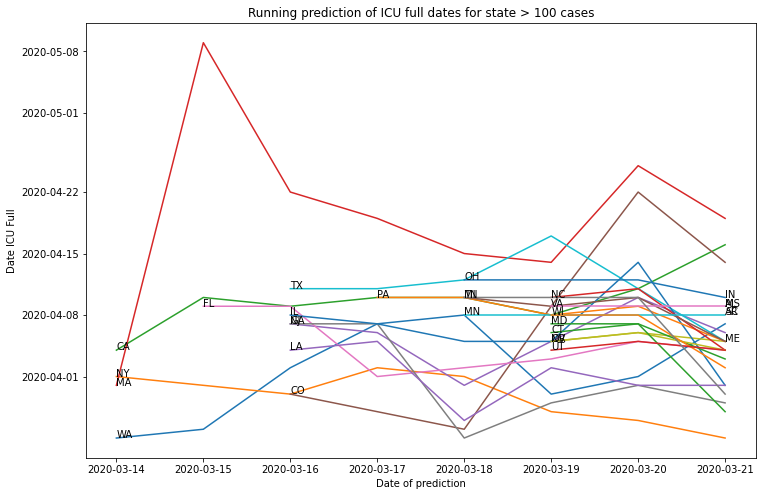

In [49]:
state_df=pd.DataFrame(create_dfs()['State'])
daterange=pd.date_range(datetime.date(2020,3,14),pd.datetime.today()).tolist()[:-1]
for dt in  daterange:
  df2=create_dfs(enddate=dt.date())
  df2[df2.Count<50]=None
  state_df[dt]=df2['ICU Full Date']

rowiter=state_df.iterrows()
while rowiter is not None:
  fig, ax = plt.subplots(figsize=(12, 8))
  try:
    for nl in range(60):
      idx,row=next(rowiter)
      valid=[isinstance(x,datetime.date) for x in list(row[1:])]
      if not np.any(valid):
        continue
      idx=np.argmax(valid)
      ax.plot(np.array(daterange)[valid],row[1:][valid].to_numpy(),label=row.State)
      ax.text(daterange[idx], row[idx+1], row.State)
  except StopIteration:
    rowiter=None
  ax.set(
      title='Running prediction of ICU full dates for state > 100 cases',
      xlabel='Date of prediction',
      ylabel='Date ICU Full')
  plt.show()

In [50]:
print(state_df.iloc[:,[0,-1]].sort_values(by=[state_df.columns[-1]]))

    State 2020-03-21 00:00:00
1      NY          2020-03-25
31     CT          2020-03-28
9      NJ          2020-03-29
44     MI          2020-03-30
36     LA          2020-03-31
12     IL          2020-03-31
30     WI          2020-04-02
15     MD          2020-04-03
34     UT          2020-04-04
8      FL          2020-04-04
24     NV          2020-04-04
16     NC          2020-04-04
18     TN          2020-04-05
11     TX          2020-04-05
10     OR          2020-04-05
43     ME          2020-04-05
13     PA          2020-04-05
6      GA          2020-04-06
0      WA          2020-04-07
40     AR          2020-04-08
17     SC          2020-04-08
26     MN          2020-04-08
19     VA          2020-04-09
45     MS          2020-04-09
243    AL          2020-04-09
21     IN          2020-04-10
28     OH          2020-04-10
7      CO          2020-04-14
2      CA          2020-04-16
3      MA          2020-04-19
14     IA                None
20     AZ                None
22     KY 

In [51]:
# Generate dataframe for since reaching 100
case_concentration=1.0
population_concentration=1.0
ratio=icu_case_ratio*case_concentration/population_concentration
gmap=us_growthseries_df.set_index('State')
tmp_df=us_plot100series_df.copy()
broke100df=tmp_df.groupby('State').min()
startdate64=np.datetime64(datetime.date(2020,3,10))
broke100df['offset']=broke100df.Date-startdate64
smap=broke100df.to_dict()['Date']
tmp_df['tmp']=tmp_df.apply(lambda x: smap[x.State],axis=1)
tmp_df['days_since_100']=tmp_df.apply(lambda x:int((x.Date-smap[x.State]).days),axis=1)
since100_df=tmp_df.loc[:,['State','days_since_100','Count']].reset_index()#.groupby('State')#.sort_values(by=['days_since_100'])
since100_df["ICUFraction"]=since100_df.Count.to_numpy()*ratio/gmap.loc[since100_df.State].ICU.to_numpy()
since100_df["PopulationPercent"]=since100_df.Count.to_numpy()/gmap.loc[since100_df.State].Population.to_numpy()*100
since100_df.tail(30)


,index,State,days_since_100,Count,ICUFraction,PopulationPercent
102,2717,WA,11,1793,0.158785,0.023546
103,2718,NY,11,11710,0.224467,0.060195
104,2719,CA,11,1364,0.015515,0.003452
105,2720,MA,9,525,0.034617,0.007617
106,2723,GA,5,507,0.021071,0.004775
107,2724,CO,7,390,0.046335,0.006772
108,2725,FL,6,659,0.011115,0.003068
109,2726,NJ,5,1327,0.053157,0.014940
110,2727,OR,1,114,0.016323,0.002703
111,2728,TX,4,581,0.008508,0.002004


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.



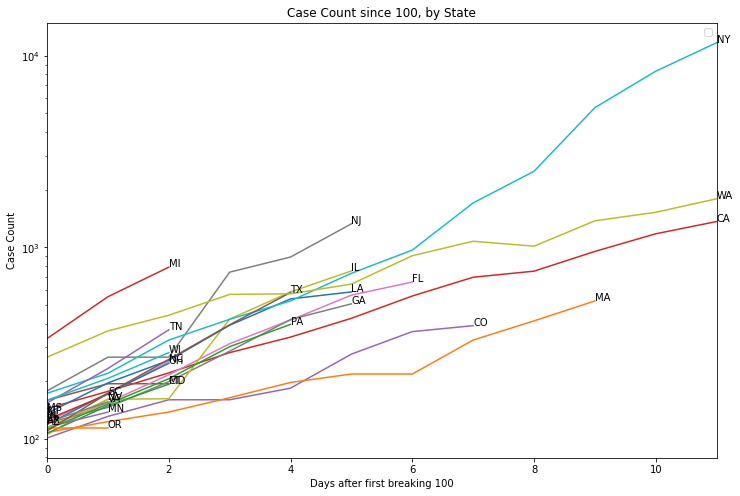

In [52]:
fig, ax = plt.subplots(figsize=(12, 8))
for key, grp in since100_df.groupby(['State']):
    grp.plot(ax=ax, kind='line', x='days_since_100', y='Count')
    ax.text(grp.days_since_100.values[-1],grp.Count.values[-1], grp.State.values[0])
ax.set(
    title='Case Count since 100, by State',
    xlabel='Days after first breaking 100',
    ylabel='Case Count')
plt.legend("")
plt.yscale('log')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.



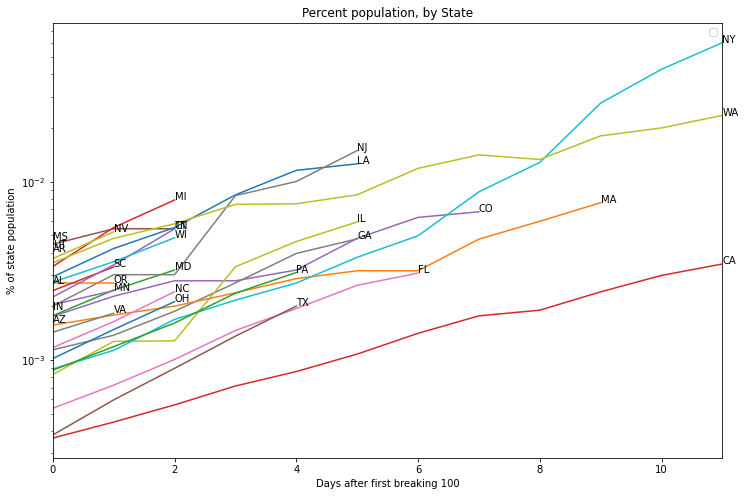

In [53]:
fig, ax = plt.subplots(figsize=(12, 8))
for key, grp in since100_df.groupby(['State']):
  grp.plot(ax=ax, kind='line', x='days_since_100', y='PopulationPercent')
  ax.text(grp.days_since_100.values[-1],grp['PopulationPercent'].values[-1], grp.State.values[0])
ax.set(
    title='Percent population, by State',
    xlabel='Days after first breaking 100',
    ylabel='% of state population')
plt.legend("")
plt.yscale('log')
plt.show()

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/core.py:1085: UserWarning:

Attempting to set identical left == right == 0.0 results in singular transformations; automatically expanding.



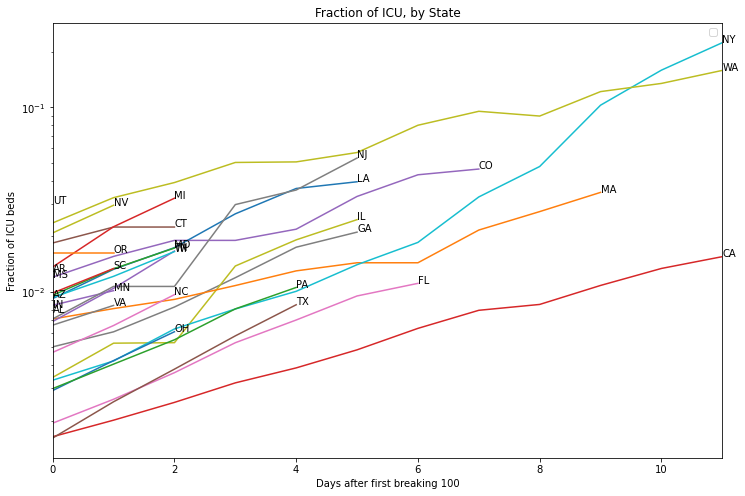

In [56]:
fig, ax = plt.subplots(figsize=(12, 8))
for key, grp in since100_df.groupby(['State']):
  grp.plot(ax=ax, kind='line', x='days_since_100', y='ICUFraction')
  ax.text(grp.days_since_100.values[-1],grp.ICUFraction.values[-1], grp.State.values[0])
ax.set(
    title='Fraction of ICU, by State',
    xlabel='Days after first breaking 100',
    ylabel='Fraction of ICU beds')
plt.legend("")
plt.yscale('log')
plt.show()

In [0]:

#TODO: Update this daily, and figure out if we can easily publish this to the web and update a website daily.
#TODO: Add the ability now to plot the growth curve of states like https://colab.research.google.com/github/machine-learning-apps/covid19-dashboard/blob/master/_notebooks/2020-03-14-covid19_growth.ipynb


In [57]:
colorscale = px.colors.sequential.Blues_r
reverse_colorscale = colorscale [::-1]
fig = px.choropleth(us_plotseries_df, title = "Cases", locations="State", locationmode="USA-states",scope="usa", color="Count", animation_frame="Day", range_color=[0,250], color_continuous_scale=colorscale)
fig.show()



In [58]:
fig2 = px.choropleth(us_growthseries_df, title="Growth Rate", locations="State", locationmode="USA-states",scope="usa", color="Growth Rate", range_color=[0,50], color_continuous_scale=colorscale)
fig2.show()


In [59]:
fig3 = px.choropleth(us_growthseries_df, title="Days to Double", locations="State", locationmode="USA-states",scope="usa", color="Days to Double", range_color=[0,10], color_continuous_scale=reverse_colorscale)
fig3.show()


In [60]:
fig4 = px.choropleth(us_growthseries_df, title="Percent Infected (bps)", locations="State", locationmode="USA-states",scope="usa", color="Population Percent (1/100 of 1%)", range_color=[0,1], color_continuous_scale=colorscale)
fig4.show()


In [61]:
fig4a = px.choropleth(us_growthseries_df, title="Hospital Beds Per Capita (1000 people)", locations="State", locationmode="USA-states",scope="usa", color="Beds per 1000", range_color=[0,10], color_continuous_scale=colorscale)
fig4a.show()


In [62]:
fig5 = px.choropleth(us_growthseries_df, title="Percent of Beds (%)", locations="State", locationmode="USA-states",scope="usa", color="Beds Percent", range_color=[0,50], color_continuous_scale=colorscale)
fig5.show()


In [63]:
fig6 = px.choropleth(us_growthseries_df, title="Percent of ICU Beds (%)", locations="State", locationmode="USA-states",scope="usa", color="ICU Percent", range_color=[0,50], color_continuous_scale=colorscale)
fig6.show()


In [64]:
fig7 = px.choropleth(us_growthseries_df, title="Days to fill ICU", locations="State", locationmode="USA-states",scope="usa", color="Days To ICU Capacity", range_color=[0,50], color_continuous_scale=colorscale)
fig7.show()

```
DaysInICU=14 days in ICU
needICU = 15% of infected
infected after DaysInICU days= infected* GR**DaysInICU
newly infected= infected*GR**DaysInICU - infected
newly need ICU = newly_infected*needICU
infected=ICUBeds/needICU
ICUBeds=(infected)*(GR**DaysInICU-1)*needICU
ICUBeds=(ICUBeds/needICU)*(GR**DaysInICU-1)*needICU
1=GR**DaysInICU-1
GR=exp(log(2)/DaysInICU)
```


In [65]:
days_in_ICU=14
# Critical GrowthRate (GR) is the steady state infection growth rate to keep the ICU load constant
# it is independent of state o
print("Critical growth rate = {:.2f}%".format(100*(np.exp(np.log(2)/days_in_ICU)-1))
)

Critical growth rate = 5.08%


Next, let's compute a simulation to determine what the GrowthRate (GR) we need for this state to NOT overwhelm the ICU.
This simulation will have to be done including  assumed length of stay in the ICU (14 days for now--can correct if we need to) (people in then people out).


*   What does GR need to be tomorrow to get the number of days to 60?
*   What if we double the number ICU-capable beds?
*   Ensure we keep the # of days in the ICU as a variable.


In [66]:
us_growthseries_df.sort_values('Days To ICU Capacity')[['State', 'Count','Growth Rate', 'Days To ICU Capacity']]

,State,Count,Growth Rate,Days To ICU Capacity
1,NY,8310,69.912061,3.465331
44,MI,552,103.332932,5.343902
9,NJ,890,49.781674,8.252223
12,IL,585,51.372363,9.542987
36,LA,538,39.758969,9.901719
31,CT,194,41.338690,10.971982
6,GA,420,41.213049,11.730218
7,CO,363,30.204787,11.910381
11,TX,394,53.515351,12.027104
30,WI,207,42.901103,12.358181


Compute how effective Italian measures were in impacting growth rates

In [67]:
italy_timeseries=global_timeseries.loc[['Italy']]
#italy_timeseries.loc[:,'3/10/20':'3/15/20']
italy_timeseries


,Province/State,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,2/2/20,2/3/20,2/4/20,2/5/20,2/6/20,2/7/20,2/8/20,2/9/20,2/10/20,2/11/20,2/12/20,2/13/20,2/14/20,2/15/20,2/16/20,2/17/20,2/18/20,2/19/20,2/20/20,2/21/20,2/22/20,2/23/20,2/24/20,2/25/20,2/26/20,2/27/20,2/28/20,2/29/20,3/1/20,3/2/20,3/3/20,3/4/20,3/5/20,3/6/20,3/7/20,3/8/20,3/9/20,3/10/20,3/11/20,3/12/20,3/13/20,3/14/20,3/15/20,3/16/20,3/17/20,3/18/20,3/19/20,3/20/20,3/21/20
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Italy,NaN,43.0,12.0,0,0,0,0,0,0,0,0,0,2,2,2,2,2,2,2,3,3,3,3,3,3,3,3,3,3,3,3,3,3,20,62,155,229,322,453,655,888,1128,1694,2036,2502,3089,3858,4636,5883,7375,9172,10149,12462,12462,17660,21157,24747,27980,31506,35713,41035,47021,53578


In [68]:
#TODO: Add fit-by-date

growth_rates = []
last_count = 0
enddate = datetime.date(2020,3,18)
startdate = datetime.date(2020,2,10)
days = (enddate - startdate).days + 1
for date in (startdate + datetime.timedelta(n) for n in range(days)):
  datestr = "" + str(date.month) + "/" + str(date.day) + "/" + str(date.year)[2:]
  count = italy_timeseries.get(datestr)
  italy_growth = 0.0
  if last_count > 0:
    italy_growth = 1.0 * int(count) /last_count - 1
  
  last_count = int(count)
  growth_rates.append([date, int(count), italy_growth])
growth_rates
italy_df = pd.DataFrame(data=growth_rates, columns=['Date', 'Count', 'Growth Rate'])
fig2 = px.line(data_frame=italy_df, x= 'Date', y='Count', title="Italian Count")
fig2.show()
fig3 = px.line(data_frame=italy_df, x= 'Date', y='Growth Rate', title="Italian Growth Rate")
fig3.update_yaxes(range=[0, 1])
fig3.show()